# Utils, imports

In [4]:
!pip install -q torchinfo

In [5]:
import multiprocessing
import os

import Levenshtein
import numpy as np
from plotly.offline import init_notebook_mode
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm

init_notebook_mode(connected=True)
import glob
from scipy.stats import spearmanr
from pprint import pprint

import plotly.express as px
import torch as th
import pandas as pd
from scipy.stats import rankdata
import json
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from collections import defaultdict
import copy
from torch.optim import AdamW
import torch
import random
import math
from torchinfo import summary

import torch.nn as nn

from sklearn.linear_model import LinearRegression

MULTIPROCESSING = False
BOXSIZE = 16
VOXELSIZE = 1
N_FOLDS = 5
BREAK_ON_FIRST_FOLD = True
MODELS_PATH = 'models'
DEBUG = True
DEVICE = 'cuda' if th.cuda.is_available() else 'cpu'
DESTABILIZING_MUTATIONS_ONLY = False
AUGMENT_DESTABILIZING_MUTATIONS = False
AUGMENT_WITH_PAIRS = False
EARLY_STOPPING_PATIENCE = 30
IS_DDG_TARGET = True
WITH_PUCCI_SOURCE = True
WITH_KAGGLE_DDG_SOURCE = True
FILLUP_NONES = False

# switchers
TRAIN = True
WANDB_TRAIN_PROJECT = 'ThermoNetV2-train'

OPTUNA = False
OPTUNA_WANDB_PROJECT = "ThermoNetV2-Optuna"
OPTUNA_TRIALS = 400

WANDB_SWEEP = False
WANDB_SWEEP_PROJECT = 'ThermoNetV2-sweep'

SUBMISSION = True


DEFAULT_PARAMS = {
    'SiLU': False,
    'diff_features': True,
    'diff_features+': False,
    'diff_features-': False,
    'LayerNorm': False,
    'GroupKFold': True,  # only use for hyperopt
    'epochs': 30,
    'AdamW': False,
}

#BEST_PARAMS = {**DEFAULT_PARAMS, **{'AdamW': True,
# 'C_dt_loss': 0.01, # 0.01
# 'OneCycleLR': False,
# 'batch_size': 256,
# 'AdamW_decay': 1.3994535042337082,
# 'dropout_rate': 0.06297340526648805,
# 'learning_rate': 0.00020503764745082723,
# 'conv_layer_num': 5,
# 'dropout_rate_dt': 0.3153179929570238,
# 'dense_layer_size': 74.1731281147114}}


BEST_PARAMS = {**DEFAULT_PARAMS, **{'AdamW': True,
 'C_dt_loss': 0.01, # 0.01
 'OneCycleLR': False,
 'batch_size': 256,
 'AdamW_decay': 1.3994535042337082,
 'dropout_rate': 0.06297340526648805,
 'learning_rate': 0.00020503764745082723,
 'conv_layer_num': 3,
 'dropout_rate_dt': 0.3153179929570238,
 'dense_layer_size': 74.1731281147114}}


WANDB_TRAIN_NAME = 'TNV4-gf51-diff-l0-h2-d2-k3-avT-dr005-b256-p_off-dest_on-e30-dt_0_01-fill_off_exp16-0'

RESNET_PARAMS = {}
RESNET_PARAMS['shape']            = (14,16,16,16)
RESNET_PARAMS['channels']         = []
RESNET_PARAMS['residual']         = []
RESNET_PARAMS['layers']           = []
RESNET_PARAMS['strides']          = [] 
RESNET_PARAMS['pools']            = []
RESNET_PARAMS['kernels']          = 3
RESNET_PARAMS['hiddens']          = [2] 
RESNET_PARAMS['averpool']         = True 
RESNET_PARAMS['batchnorm']        = True 
RESNET_PARAMS['bias']             = False 
RESNET_PARAMS['dropouts']         = 0.05
RESNET_PARAMS['dense_layer_size'] = 2
RESNET_PARAMS['silu']             = BEST_PARAMS['SiLU']


try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    WANDB_API_KEY = user_secrets.get_secret("WANDB_API_KEY")

    print('Running in Kaggle')
    WILDTYPE_PDB = '../input/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb'
    PDB_PATH = '../input/thermonet-wildtype-relaxed'
    TRAIN_FEATURES_PATH = '../input/thermonet-features/Q3214.npy'
    TRAIN_TARGETS_PATH = ''
    TEST_CSV = '../input/novozymes-enzyme-stability-prediction/test.csv'
    TEST_FEATURES_PATH = '../input/thermonet-features/nesp_features.npy'
    PUBLIC_SUBMISSIONS=[
        '../input/rmsd-from-molecular-dynamics/submission_rmsd.csv',     # LB: 0.507
        '../input/plldt-ddg-demask-sasa/deepddg-ddg.csv',                # LB: 0.451
        '../input/novo-esp-eli5-performant-approaches-lb-0-451/submission.csv',  # 0.451
        '../input/nesp-alphafold-getarea-exploration/submission.csv',                   # 0.407
    ]    
    TRAIN_FEATURES_DIR = '../input/nesp-9936-unique-mutations-voxel-features'
    

except Exception as ex:
    print('Running locally')
    WILDTYPE_PDB = 'nesp/thermonet/wildtypeA.pdb'
    PDB_PATH = 'nesp/thermonet/'
    TRAIN_FEATURES_PATH = 'data/train_features/features.npy'
    TRAIN_TARGETS_PATH = 'data/train_features/dataset.csv'
    TEST_FEATURES_PATH = 'data/nesp/nesp_features.npy'
    TEST_CSV = 'data/nesp/test.csv'
    PUBLIC_SUBMISSIONS=glob.glob('data/nesp/public_submissions/*.csv')
    TRAIN_FEATURES_DIR = 'data/train_features/'
    WANDB_API_KEY='your_key_here'

os.makedirs(MODELS_PATH, exist_ok=True)

Running in Kaggle


In [6]:
import wandb

"""
Add WANDB_API_KEY with your wandb.ai API key to run the code. 
"""
wandb.login(key=WANDB_API_KEY)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
def save_avg_features():
    df = pd.read_csv(f'{TRAIN_FEATURES_DIR}/dataset.csv')
    df['features'] = df.apply(lambda r: f'{TRAIN_FEATURES_DIR}/features/{r.PDB_chain}_{r.wildtype}{r.pdb_position}{r.mutant}.npy', axis=1)
    df = df[df.features.apply(lambda v: os.path.exists(v))]
    df.features = [np.load(f) for f in tqdm(df.features, desc="loading features")]
    df.features = df.features.apply(lambda f: f.mean(axis=(1,2,3)))
    df.to_pickle('dataset_14.pkl')
    
#save_avg_features()


# Load training data

In [6]:
def load_data():
    print("1. Loading csv datasets")
    df = pd.read_csv(f'{TRAIN_FEATURES_DIR}/dataset.csv')
    df.source = df.source.apply(eval)
    print(f'Total unique mutations: {len(df)}')

    df['features'] = df.apply(lambda r: f'{TRAIN_FEATURES_DIR}/features/{r.PDB_chain}_{r.wildtype}{r.pdb_position}{r.mutant}.npy', axis=1)
    df = df[df.features.apply(lambda v: os.path.exists(v))]

    if FILLUP_NONES:
        df_filled = df[(~df.dT.isna()) & (~df.ddG.isna())]   
        df = df[(~df.dT.isna()) | (~df.ddG.isna())] 
        dT2ddG = LinearRegression().fit(df_filled.dT.values.reshape(-1,1), df_filled.ddG.values)
        ddG2dT = LinearRegression().fit(df_filled.ddG.values.reshape(-1,1), df_filled.dT.values)
        df.dT  = df.apply((lambda r: ddG2dT.predict([[r.ddG]])[0] if math.isnan(r.dT)  else r.dT), axis=1)
        df.ddG = df.apply((lambda r: dT2ddG.predict([[r.dT]])[0]  if math.isnan(r.ddG) else r.ddG), axis=1)
    
    print(f'Total mutations with features: {len(df)}')

    if not WITH_PUCCI_SOURCE:
        df = df[df.source.apply(lambda v: v != ['pucci-proteins-appendixtable1.xlsx'])]

    if not WITH_KAGGLE_DDG_SOURCE:
        df = df[df.source.apply(lambda v: v != ['ddg-xgboost-5000-mutations-200-pdb-files-lb-0-40.csv'])]

    print(f'Total mutations after filtering: {len(df)}')

    df.features = [np.load(f) for f in tqdm(df.features, desc="2. Loading features")]


    df_train = df

    if DESTABILIZING_MUTATIONS_ONLY:
        print('Keeping destabilizing mutations only')
        df_train = df_train[((df_train.ddG < 0))  & ((df_train.dT < 0) | df_train.dT.isna())].reset_index(drop=True).copy() # best for ddG
    else:
        df_train = df_train[(~df_train.ddG.isna())].reset_index(drop=True).copy() # best for ddG
    
    if AUGMENT_DESTABILIZING_MUTATIONS:
        print('Augmenting destabilizinb mutations')
        df_pos = df_train[df_train.ddG > 0].copy()
        df_neg = df_train[df_train.ddG < 0]
        print(df_pos.shape, df_neg.shape)
        df_pos.features = df_pos.features.apply(lambda f: np.concatenate([f[7:], f[:7]], axis=0))
        df_pos.ddG = -df_pos.ddG
        df_pos.dT = -df_pos.dT
        df_train = pd.concat([df_pos, df_neg], axis=0).sample(frac=1.).reset_index(drop=True)        
    else:
        df_train = df_train.reset_index(drop=True)
    return df_train

df_train = load_data()
print('Filtered samples: ',len(df_train))
df_train

1. Loading csv datasets
Total unique mutations: 14656
Total mutations with features: 12167
Total mutations after filtering: 12167


2. Loading features:   0%|          | 0/12167 [00:00<?, ?it/s]

Filtered samples:  10781


,sequence,wildtype,pdb_position,seq_position,mutant,ddG,dT,wT,pH,source,PDB_chain,features
0,AAQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,D,36,36,A,0.705833,NaN,NaN,7.0,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1msiA,[[[[0.16073775 0.02624079 0.00722922 0.0263687...
1,AAQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,D,58,58,N,-0.120000,NaN,NaN,7.0,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1msiA,[[[[1.00000000e+00 1.83487193e-01 3.07613411e-...
2,AAQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,E,25,25,A,-0.050000,NaN,NaN,7.0,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1msiA,[[[[3.38143335e-06 3.03279778e-05 3.04589878e-...
3,AAQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,R,23,23,A,-0.763333,NaN,NaN,7.0,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1msiA,[[[[0.00000000e+00 0.00000000e+00 0.00000000e+...
4,AAQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,R,39,39,A,-0.726667,NaN,NaN,7.0,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1msiA,[[[[0.0076158 0.09321734 0.13197631 0.0698161...
...,...,...,...,...,...,...,...,...,...,...,...,...
10776,YSIEADKKFKYSVKLSDYPTLQDAASAAVDGLLIDRDYNFYGGETV...,R,382,269,S,-17.400000,-5.2,NaN,7.4,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1clwA,[[[[0.00544725 0.06888345 0.3927299 0.1319893...
10777,YSIEADKKFKYSVKLSDYPTLQDAASAAVDGLLIDRDYNFYGGETV...,T,235,122,I,-1.600000,-0.4,NaN,7.4,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1clwA,[[[[6.02426507e-04 2.46603597e-03 4.25419226e-...
10778,YSIEADKKFKYSVKLSDYPTLQDAASAAVDGLLIDRDYNFYGGETV...,G,244,131,R,-1.330000,NaN,NaN,7.4,"[dataset_S2648.csv, iStable2.0 - s3568]",1tyvA,[[[[3.29420297e-02 1.07765760e-01 2.73649860e-...
10779,YSIEADKKFKYSVKLSDYPTLQDAASAAVDGLLIDRDYNFYGGETV...,R,285,172,K,-3.430000,NaN,NaN,7.4,"[dataset_S2648.csv, iStable2.0 - s3568]",1tyvA,[[[[2.24163487e-03 1.26180000e-02 7.25209257e-...


[0 1 2 3 4 5 6 7 8 9] 8624
[174 175 176 177 178 179 180 181 182 183] 2157


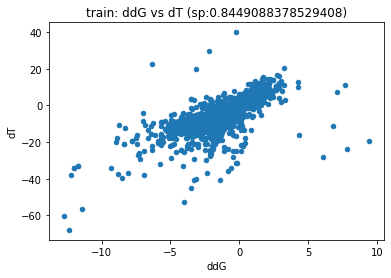

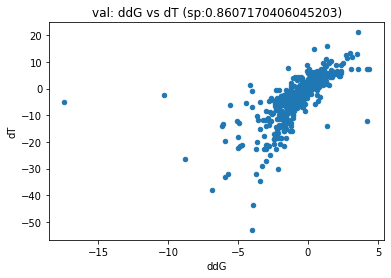

In [6]:
#BEST_PARAMS['GroupKFold'] = True

if BEST_PARAMS['GroupKFold']:
    groups = df_train.sequence
else:
    groups = range(len(df_train))                             
kfold = GroupKFold(N_FOLDS)
for fold, (train_idx, val_idx) in enumerate(kfold.split(df_train, groups=groups)):    
    df_train_f0 = df_train.loc[train_idx]
    df_val_f0 = df_train.loc[val_idx]
    if fold == 0:
        break
    
df_train_f0_filled = df_train_f0[(~df_train_f0.ddG.isna()) & (~df_train_f0.dT.isna())]
df_val_f0_filled   = df_val_f0[(~df_val_f0.ddG.isna()) & (~df_val_f0.dT.isna())]

df_train_f0.plot.scatter(x='ddG', y='dT', title=f'train: ddG vs dT (sp:{spearmanr(df_train_f0_filled.ddG, df_train_f0_filled.dT).correlation})')
df_val_f0.plot.scatter(x='ddG', y='dT', title=f'val: ddG vs dT (sp:{spearmanr(df_val_f0_filled.ddG, df_val_f0_filled.dT).correlation})')
    
print(train_idx[:10], len(train_idx))
print(val_idx[:10], len(val_idx))

In [7]:
df_train[:1]['features'].values[0].shape

(14, 16, 16, 16)

SpearmanrResult(correlation=0.850990345966358, pvalue=0.0)
3262


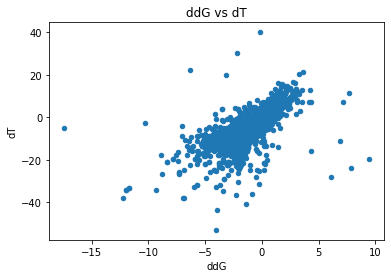

In [13]:
#df_train_cp = df_train[(df_train.ddG > 0.0) & (df_train.dT > 0.0)] # stab mutations   0.71             (868)
#df_train_cp = df_train[(df_train.ddG < 0.0) & (df_train.dT < 0.0)] # destab mutations  0.77            (2240)
#df_train_cp = df_train[(~df_train.ddG.isna()) & (~df_train.dT.isna())] # stab + destab mutations 0.849  (3496)
#df_train_cp = df_train[(df_train.ddG == 0.0) & (~df_train.dT.isna())] # stab mutations                (43)
#df_train_cp = df_train[(~df_train.ddG.isna()) & (df_train.dT == 0.0)] # stab mutations                (33)

df_train_cp = df_train[(~df_train.ddG.isna()) & (~df_train.dT.isna()) & (~df_train.pH.isna())] # stab + destab mutations 0.849  (3496)

df_train_cp.plot.scatter(x='ddG', y='dT', title='ddG vs dT')
print(spearmanr(df_train_cp.ddG, df_train_cp.dT))
print(len(df_train_cp))


In [ ]:
from sklearn.linear_model import LinearRegression
#X = np.concatenate([df_train_cp.dT.values.reshape(-1,1), df_train_cp.ddG.values.reshape(-1,1)], axis=1)
X = df_train_cp.dT.values.reshape(-1,1)
y = np.array(df_train_cp.ddG)
reg = LinearRegression().fit(X, y)
print(reg.coef_)
print(reg.score(X, y))



In [ ]:
from matplotlib import pyplot as plt

ddgP = reg.predict(X)
plt.scatter(ddgP,y)
print(spearmanr(ddgP, y))


In [ ]:
df_train.dT.plot.hist(title='Distribution of dT')

<AxesSubplot:title={'center':'Distribution of ddG'}, ylabel='Frequency'>

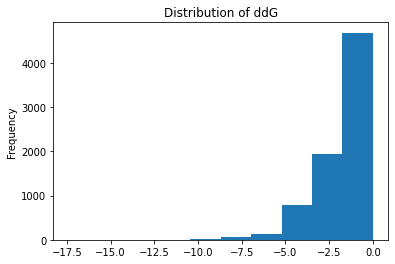

In [11]:
df_train.ddG.plot.hist(title='Distribution of ddG')

In [ ]:
df_train.plot.scatter(x='ddG', y='dT', title='ddG vs dT')
print(spearmanr(df_train.ddG, df_train.dT))

In [ ]:
df_train.groupby('sequence').features.count().plot.hist(title='Mutations per sequence', bins=50)

# Model

In [7]:
class ThermoNet2_old(th.nn.Module):
    def __init__(self, params):
        super().__init__()

        if params['diff_features+']:
            CONV_LAYER_SIZES = [21, 23, 31, 39, 55, 85, 128]
            FLATTEN_SIZES = [0, 8232, 7452, 4000, 3072, 2295, 1024]
        elif params['diff_features-']:
            CONV_LAYER_SIZES = [7, 9, 15, 23, 40, 70, 128]
            FLATTEN_SIZES = [0, 8232, 7452, 4000, 3072, 1890, 1024]            
        else:
            CONV_LAYER_SIZES = [14, 16, 24, 32, 48, 78, 128]
            FLATTEN_SIZES = [0, 5488, 5184, 4000, 3072, 2106, 1024]
            
        

        dropout_rate = params['dropout_rate']
        dropout_rate_dt = params['dropout_rate_dt']
        dense_layer_size = int(params['dense_layer_size'])
        layer_num = int(params['conv_layer_num'])
        silu = params['SiLU']

        self.params = params
        if silu:
            activation = th.nn.SiLU()
        else:
            activation = th.nn.ReLU()

        model = [
            th.nn.Sequential(
                *[th.nn.Sequential(
                    th.nn.Conv3d(in_channels=CONV_LAYER_SIZES[l], out_channels=CONV_LAYER_SIZES[l + 1], kernel_size=(3, 3, 3)),
                    activation
                ) for l in range(layer_num)]
            ),
            th.nn.MaxPool3d(kernel_size=(2,2,2)),
            th.nn.Flatten(),
        ]
        flatten_size = FLATTEN_SIZES[layer_num]
        if self.params['LayerNorm']:
            model.append(th.nn.LayerNorm(flatten_size))
        self.model = th.nn.Sequential(*model)

        self.ddG = th.nn.Sequential(
            th.nn.Dropout(p=dropout_rate),
            th.nn.Linear(in_features=flatten_size, out_features=dense_layer_size),
            activation,
            th.nn.Dropout(p=dropout_rate),
            th.nn.Linear(in_features=dense_layer_size, out_features=1)
        )
        self.dT = th.nn.Sequential(
            th.nn.Dropout(p=dropout_rate_dt),
            th.nn.Linear(in_features=flatten_size, out_features=dense_layer_size),
            activation,
            th.nn.Dropout(p=dropout_rate_dt),
            th.nn.Linear(in_features=dense_layer_size, out_features=1)
        )


    def forward(self, x):
        if self.params['diff_features']:
            x[:, 7:, ...] -= x[:, :7, ...]
        if self.params['diff_features-']:
            x = x[:, 7:, ...] - x[:, :7, ...]
        if self.params['diff_features+']:
            x = torch.concat((x[:, :, ...], x[:, :7, ...]), dim = 1)
            x[:, 14:, ...] = x[:, 7:14, ...] - x[:, :7, ...]
        x = self.model(x)
        ddg = self.ddG(x)
        dt = self.dT(x)
        return ddg.squeeze(), dt.squeeze()
    
    
class ResNet3DBlock(nn.Module):
    def __init__(self, in_channels,  out_channels, kernel = 3, stride = 1, layers=2,  mode = 'zeros',  batchnorm=True, bias=False, residual=0):
        super(ResNet3DBlock, self).__init__()

        layers, channels, padding = [],  [in_channels] + [out_channels]*layers,   kernel // 2
        for i in range(len(channels)-1): 
            layers += [ nn.Conv3d(channels[i], channels[i+1], kernel_size=kernel, padding=padding, padding_mode=mode,
                                  stride=stride if i==0 else 1,  bias=bias) ]
            if batchnorm:
                layers += [ nn.BatchNorm3d(num_features=channels[i+1]) ]
            if i < len(channels)-2:
                layers += [ nn.ReLU(inplace=True) ]
        
        self.block = nn.Sequential(*layers)                      

        self.batchnorm = None
        if  residual == 0:
            self.align = None
        elif residual == 1:
            self.align = nn.Identity()
        elif residual == 2:
            self.align     = nn.Conv3d(in_channels, out_channels, kernel_size=1,  stride=stride, bias=bias)
            self.batchnorm = nn.BatchNorm3d(num_features=out_channels) if batchnorm else None
        elif residual == 3:
            self.align = nn.Parameter( torch.randn(in_channels, out_channels) )  # TODO
        else:
            print("Error: wrong kind of residual !!!")            

        self.relu = nn.ReLU()

    def forward(self, x):
        y = self.block(x)
        if self.align is not None:            
            y2 = self.align(x)
            if self.batchnorm is not None:
                y2 = self.batchnorm(y2)
            y += y2
        
        y = self.relu(y)
        return y

class TermoResNet3D(nn.Module):
    def __init__(self,
                 shape     = (1, 128, 128, 128),    # Input image shape (channels, height, width)        
                 layers    = 2,                     # Layers in block
                 channels  = [],                    # Conv3d                         
                 kernels   = 3,  
                 strides   = 1,
                 mode      = 'zeros',        
                 batchnorm = True,           # batchnorm
                 bias      = False,
                 pools     = 0,              # Pooling
                 dropouts  = 0.,             # Dropout
                 hiddens   = [],             # Add output hidden layers
                 residual  = [],             # Add residual path                     
                 averpool  = True,
                 dense_layer_size = 64,
                 silu = True
                 ):                                                        
        super(TermoResNet3D, self).__init__()   
        
        dense_layer_size = int(dense_layer_size)

        if type(layers)   == int:    layers   = [layers]   * len(channels)         
        if type(strides)  == int:    strides  = [strides]  * len(channels)         
        if type(pools)    == int:    pools    = [pools]    * len(channels)                                    
        if type(kernels)  == int:    kernels  = [kernels]  * len(channels)   
        if type(dropouts) == float:  dropouts = [dropouts] * (len(hiddens) + 3)   

        in_channels, h, w, d = shape                                                      
        channels = [in_channels] + channels
        self.layers = []
        for i in range(len(channels)-1):            
            self.layers +=  [ ResNet3DBlock(channels[i], channels[i+1], kernel=kernels[i], residual=residual[i], layers=layers[i], stride=strides[i], mode=mode, batchnorm=batchnorm, bias=bias)  ]            
            if strides[i] > 1:
                h = int( (h + 2*(kernels[i]//2) - kernels[i]) / strides[i] + 1)
                w = int( (w + 2*(kernels[i]//2) - kernels[i]) / strides[i] + 1)
                d = int( (d + 2*(kernels[i]//2) - kernels[i]) / strides[i] + 1)
            if pools[i] > 1:
                self.layers += [ nn.MaxPool3d(kernel_size = pools[i], stride = pools[i]) ]                
                h = int( (h - pools[i]) / pools[i] + 1)
                w = int( (w - pools[i]) / pools[i] + 1)
                d = int( (d - pools[i]) / pools[i] + 1)
        
        if averpool:
            self.layers += [ nn.AdaptiveAvgPool3d((1, 1, 1)) ]
            h, w, d = 1, 1, 1

        self.layers += [ nn.Flatten(1) ]

        hiddens = [channels[-1] * h * w * d] + hiddens
        for i in range( len(hiddens)-1):
            if dropouts[i] > 0:        
                self.layers += [ nn.Dropout(p=dropouts[i]) ]    
            self.layers += [ nn.Linear(hiddens[i], hiddens[i+1] ) ]
            if i < len(hiddens)-2:                            
                self.layers += [ nn.ReLU() ]

        self.model = nn.Sequential(*self.layers) 
        
        if silu:
            activation = th.nn.SiLU()
        else:
            activation = th.nn.ReLU()
            
        self.ddG = th.nn.Sequential(
            th.nn.Dropout(p=dropouts[-1]),
            th.nn.Linear(in_features=hiddens[-1], out_features=dense_layer_size),
            activation,
            th.nn.Dropout(p=dropouts[-1]),
            th.nn.Linear(in_features=dense_layer_size, out_features=1)
        )
        self.dT = th.nn.Sequential(
            th.nn.Dropout(p=dropouts[-2]),
            th.nn.Linear(in_features=hiddens[-1], out_features=dense_layer_size),
            activation,
            th.nn.Dropout(p=dropouts[-2]),
            th.nn.Linear(in_features=dense_layer_size, out_features=1)
        )
 
    def forward(self, x): 
        x[:, 7:, ...] -= x[:, :7, ...]
        x = self.model(x)
        ddg = self.ddG(x)
        dt = self.dT(x)
        return ddg.squeeze(), dt.squeeze()

    def get(self, x):
        res = []
        for layer in self.layers:
            x = layer(x)
            res.append(x.data.cpu().numpy())
        return res

def load_pytorch_model(fname, params=BEST_PARAMS):
    #model = ThermoNet2(params)
    model =TermoResNet3D(**RESNET_PARAMS)
    model.load_state_dict(th.load(fname))
    return model

def evaluate(model, dl_val, params):
    criterion = th.nn.MSELoss()
    model.eval()
    losses = []
    ddg_preds = []
    ddg_trues  = []
    dt_preds = []
    dt_trues  = []
    ddg_losses = []
    dt_losses = []
    with th.no_grad():
        for x, ddg, dt in tqdm(dl_val, desc='Eval', disable=True):
            ddg_pred, dt_pred = model(x.to(DEVICE))
            ddg_preds.append(ddg_pred.cpu().numpy())
            ddg_trues.append(ddg.cpu().numpy())
            dt_preds.append(dt_pred.cpu().numpy())
            dt_trues.append(dt.cpu().numpy())
            
            ddg = ddg.to(DEVICE)
            dt = dt.to(DEVICE)
            not_nan_ddg = ~th.isnan(ddg)
            ddg_loss = criterion(ddg[not_nan_ddg], ddg_pred[not_nan_ddg])

            not_nan_dt = ~th.isnan(dt)
            dt_loss = criterion(dt[not_nan_dt], dt_pred[not_nan_dt])

            loss = th.stack([ddg_loss, dt_loss * params['C_dt_loss']])
            loss = loss[~th.isnan(loss)].sum()
            if not np.isnan(loss.item()):
                losses.append(loss.item())
            if not np.isnan(ddg_loss.item()):
                ddg_losses.append(ddg_loss.item())
            if not np.isnan(dt_loss.item()):
                dt_losses.append(dt_loss.item())
          
        
    ddg_sp = spearmanr(np.concatenate(ddg_preds),np.concatenate(ddg_trues)).correlation
    dt_sp = spearmanr(np.concatenate(dt_preds),np.concatenate(dt_trues)).correlation

    return np.mean(losses), np.mean(ddg_losses), np.mean(dt_losses), ddg_sp, dt_sp, np.concatenate(ddg_preds), np.concatenate(dt_preds)

    
if DEBUG:
    params = copy.copy(BEST_PARAMS)
    params['diff_features'] = False
    #tn2 =ThermoNet2(params)
    tn2 =TermoResNet3D(**RESNET_PARAMS)
    #print([out.shape for out in tn2.forward(th.randn((2, 14, 16, 16, 16)))])
    #print(tn2)
    
summary(tn2, input_size=(1, 14, 16, 16, 16))

Layer (type:depth-idx)                   Output Shape              Param #
TermoResNet3D                            --                        --
├─Sequential: 1-1                        [1, 2]                    --
│    └─AdaptiveAvgPool3d: 2-1            [1, 14, 1, 1, 1]          --
│    └─Flatten: 2-2                      [1, 14]                   --
│    └─Dropout: 2-3                      [1, 14]                   --
│    └─Linear: 2-4                       [1, 2]                    30
├─Sequential: 1-2                        [1, 1]                    3
│    └─Dropout: 2-5                      [1, 2]                    --
│    └─Linear: 2-6                       [1, 2]                    6
├─Sequential: 1-3                        --                        (recursive)
│    └─ReLU: 2-7                         [1, 2]                    --
├─Sequential: 1-4                        --                        (recursive)
│    └─Dropout: 2-8                      [1, 2]                    --

# Dataset

In [11]:
class ThermoNet2Dataset(Dataset):
    def __init__(self, df=None, features=None, train=False):
        self.df = df
        self.features = features
        self.groups_info = {}
        self.train = train
        self.__load()
        
    def __load(self):
        if self.df is not None and AUGMENT_WITH_PAIRS:
            # cache indexes of group items
            self.df['group_name'] = self.df.PDB_chain + '_' + self.df.features.apply(lambda f: str(f[:7].mean()))
            for group in self.df.groupby('group_name'):
                self.groups_info[group[0]] = self.df.index[self.df.group_name == group[0]].tolist() 

    def __getitem__(self, item):        
        if self.df is not None:                        
            if 'ddG' in self.df.columns:
                if self.train and AUGMENT_WITH_PAIRS:
                    features, ddG, dT = self.__augmen_with_pairs(item) 
                else:
                    r = self.df.iloc[item]
                    features, ddG, dT = r.features, r.ddG, r.dT
                return th.as_tensor(features, dtype=th.float), th.tensor(ddG, dtype=th.float), th.tensor(dT, dtype=th.float)
            else:
                r = self.df.iloc[item]
                return th.as_tensor(r.features, dtype=th.float)
        else:
            return th.as_tensor(self.features[item], dtype=th.float)        

    def __len__(self):
        return len(self.df) if self.df is not None else len(self.features)
            
    def __augmen_with_pairs(self, item):
        global MERGED
        r = self.df.iloc[item]
        defaults = r.features, r.ddG, r.dT
        group_name = r.group_name     
                
        group_item_indxs = self.groups_info[group_name]
        
        
        if len(group_item_indxs)<2:
            return defaults

        group_pair_indxs = random.sample(group_item_indxs,2)

        df1 = self.df.loc[group_pair_indxs[0]]
        df2 = self.df.loc[group_pair_indxs[1]]
        
        if df1.ddG is not None and df2.ddG is not None:
            ddG = df2.ddG - df1.ddG
        else:
            ddG = None

        if df1.dT is not None and df2.dT is not None:
            dT = df2.dT - df1.dT
        else:
            dT = None

        if ddG is None and dT is None:
            defaults
        else:
            MERGED += 1
            if df1.features[:7].mean() != df2.features[:7].mean():
                #!!! different wildtypes (maybe differend datasets)
                return defaults
            
            # merge features
            features = np.empty(df1.features.shape)
            features[:7] = df1.features[7:]
            features[7:] = df2.features[7:]
            return features, ddG, dT

if DEBUG:
    ds = ThermoNet2Dataset(df_train, train=True)
    feat, t1, t2 = next(iter(DataLoader(ds, batch_size=BEST_PARAMS['batch_size'])))
    print(feat.shape, t1.shape, t2.shape)

NameError: name 'df_train' is not defined

# Train

In [9]:
def train_model(name, dl_train, dl_val, params, wandb_enabled=True, project='thermonetv2'):
    #model = ThermoNet2(params).to(DEVICE)
    model = TermoResNet3D(**RESNET_PARAMS).to(DEVICE)
    
    if params['AdamW']:
        def get_optimizer_params(model, encoder_lr, weight_decay=0.0):
            no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
            optimizer_parameters = [
                {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                 'lr': encoder_lr, 'weight_decay': weight_decay},
                {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                 'lr': encoder_lr, 'weight_decay': 0.0},
            ]
            return optimizer_parameters

        optimizer_parameters = get_optimizer_params(model,
                                                    encoder_lr=params['learning_rate'],
                                                    weight_decay=params['AdamW_decay'])
        optim = AdamW(optimizer_parameters, lr=params['learning_rate'])
    else:
        optim = th.optim.Adam(model.parameters(), lr=params['learning_rate'])

    scheduler = None
    if params['OneCycleLR']:
        from torch.optim.lr_scheduler import OneCycleLR
        scheduler = OneCycleLR(optim, max_lr=params['learning_rate'],
                                                     steps_per_epoch=len(dl_train), epochs=params['epochs'],
                                                     pct_start=0.)
    criterion = th.nn.MSELoss()
    best_model = None
    min_epoch = -1
    val_losses = defaultdict(lambda: [])

    run = None
    if wandb_enabled:
        run = wandb.init(project=project, name=name, mode='online' if wandb_enabled else 'disabled')

    with tqdm(range(params['epochs']), desc='Epoch') as prog:
        min_loss = np.inf
        for epoch in prog:
            model.train()
            for x, ddg, dt in tqdm(dl_train, desc='Train', disable=True):
                ddg_pred, dt_pred = model(x.to(DEVICE))
                ddg = ddg.to(DEVICE)
                dt = dt.to(DEVICE)
                loss = None
                any_ddg = ~th.isnan(ddg)
                if th.any(any_ddg):
                    loss = criterion(ddg[any_ddg], ddg_pred[any_ddg])
                any_dt = ~th.isnan(dt)
                if th.any(any_dt):
                    dt_loss = criterion(dt[any_dt], dt_pred[any_dt])
                    if loss is None:
                        loss = dt_loss * params['C_dt_loss']
                    else:
                        loss += dt_loss * params['C_dt_loss']
                optim.zero_grad()
                loss.backward()
                optim.step()
                if scheduler is not None:
                    scheduler.step()

            eval_loss, eval_ddg_loss, eval_dt_loss, eval_ddg_sp, eval_dt_sp = evaluate(model, dl_val, params)[:5]
            val_losses['loss'].append(eval_loss)
            val_losses['ddg_loss'].append(eval_ddg_loss)
            val_losses['dt_loss'].append(eval_dt_loss)
            val_losses['ddg_sp'].append(eval_ddg_sp)
            val_losses['dt_sp'].append(eval_dt_sp)
            
            if run is not None:
                run.log({'val_loss': eval_loss, 'val_ddg_loss': eval_ddg_loss, 'val_dt_loss': eval_dt_loss,
                         'val_ddg_sp': eval_ddg_sp, 'val_dt_sp': eval_dt_sp,
                         'lr': scheduler.get_last_lr()[0] if scheduler is not None else params['learning_rate']})
            if eval_loss < min_loss:
                min_loss = eval_loss
                min_epoch = epoch
                best_model = copy.deepcopy(model)
            prog.set_description(
                f'Epoch: {epoch}; val_loss:{eval_loss:.02f}; min_val_loss:{min_loss:.02f}; val_ddg_loss:{eval_ddg_loss:.02f}; val_dt_loss:{eval_dt_loss:.02f}; val_ddg_sp:{eval_ddg_sp:.03f}; val_dt_sp:{eval_dt_sp:.03f}')
            if epoch - min_epoch > EARLY_STOPPING_PATIENCE:
                print('Early stopping')
                break

    if run is not None:
        art = wandb.Artifact("thermonet2", type="model")
        fname = f'{MODELS_PATH}/{name}.pt'
        th.save(best_model.state_dict(), fname)
        art.add_file(fname)
        run.log_artifact(art)
        run.finish()
    return best_model, val_losses


def run_train(name, params, project='thermonetv2'):
    os.makedirs(MODELS_PATH, exist_ok=True)
    val_losses = []
    thermonet_models = []
    kfold = GroupKFold(N_FOLDS)
    if params['GroupKFold']:
        groups = df_train.sequence
    else:
        groups = range(len(df_train))
    for fold, (train_idx, val_idx) in enumerate(
            tqdm(kfold.split(df_train, groups=groups), total=N_FOLDS, desc="Folds")):
        exp_name = f'{name}-{fold}'
        fname = f'{MODELS_PATH}/{exp_name}.pt'
        ds_train = ThermoNet2Dataset(df_train.loc[train_idx], train=True)
        ds_val = ThermoNet2Dataset(df_train.loc[val_idx])

        batch_size = params['batch_size']
        dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
        dl_val = DataLoader(ds_val, batch_size=64, pin_memory=True, drop_last=True)

        model, losses = train_model(exp_name, dl_train, dl_val, params, wandb_enabled=True, project=project)
        val_losses.append(losses)
        thermonet_models.append(model)
        if BREAK_ON_FIRST_FOLD:
            break

    d = pd.DataFrame([{k: np.min(v) if k in ['loss', 'ddg_loss', 'dt_loss'] else np.max(v) for k, v in l.items()} for l in val_losses]).mean().to_dict()
    with wandb.init(project=f'{project}-CV', name=name) as run:
        run.log(d)
    return thermonet_models, d


if TRAIN:
    params = copy.copy(BEST_PARAMS)
    thermonet_models = run_train(WANDB_TRAIN_NAME, params, project=WANDB_TRAIN_PROJECT)[0]

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

wandb: Currently logged in as: abeyn (qudata). Use `wandb login --relogin` to force relogin


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ddg_loss,██▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
val_dt_loss,███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
val_loss,██▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
lr,0.00021
val_ddg_loss,2.98647
val_ddg_sp,nan
val_dt_loss,202.40078
val_dt_sp,nan
val_loss,4.64248


ddg_loss,▁
dt_loss,▁
loss,▁
ddg_loss,2.98647
ddg_sp,nan
dt_loss,202.40078
dt_sp,nan
loss,4.64248


# Submission

All models are stored in Wandb, so downloading models to the localhost here.

In [6]:
def collect_wandb_models(name):
    runs = wandb.Api().runs(
        path='qudata/ThermoNetV2-train',
    )
    with tqdm(runs, desc='Downloading artefacts') as prog:
        for run in prog:
            art = run.logged_artifacts()
            if len(art) > 0:
                if name in run.name:
                    prog.set_description(run.name)
                    art[0].download()


if SUBMISSION:
    collect_wandb_models(WANDB_TRAIN_NAME)

In [7]:
glob.glob(f'artifacts/*/{WANDB_TRAIN_NAME}*.pt')

['artifacts/thermonet2:v116/TNV4-gf51-diff-l0-h2-d2-k3-avT-dr005-b256-p_off-dest_on-e30-dt_0_01-fill_off_exp16-0.pt']

In [9]:
def check_wandb_model():
    params = copy.copy(BEST_PARAMS)
    model = load_pytorch_model(glob.glob(f'artifacts/*/{WANDB_TRAIN_NAME}*.pt')[0])
    model.to(DEVICE)
    model.eval()    
    if params['GroupKFold']:
        groups = df_train.sequence
    else:
        groups = range(len(df_train))                             
    kfold = GroupKFold(N_FOLDS)
    for fold, (train_idx, val_idx) in enumerate(tqdm(kfold.split(df_train, groups=groups), total=N_FOLDS, desc="Folds")):
        ds_val = ThermoNet2Dataset(df_train.loc[val_idx])
        dl_val = DataLoader(ds_val, batch_size=64, pin_memory=True, drop_last=True)
        eval_loss, eval_ddg_loss, eval_dt_loss, eval_ddg_sp, eval_dt_sp = evaluate(model, dl_val, params)[:5]
        print(f'val_loss: {eval_loss:.4f}, ddG_loss: {eval_ddg_loss:.4f}, dT_loss: {eval_dt_loss:.4f}, val_ddG_sp: {eval_ddg_sp:.3f}, val_dT_sp: {eval_dt_sp:.3f}')
        break
    return ds_val, val_idx
        
ds_val, val_idx = check_wandb_model()

NameError: name 'df_train' is not defined

In [9]:
def gen_mutations(name, df,
                  wild="VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQ""RVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGT""NAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKAL""GSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK"):
    result = []
    for _, r in df.iterrows():
        ops = Levenshtein.editops(wild, r.protein_sequence)
        assert len(ops) <= 1
        if len(ops) > 0 and ops[0][0] == 'replace':
            idx = ops[0][1]
            result.append([ops[0][0], idx + 1, wild[idx], r.protein_sequence[idx]])
        elif len(ops) == 0:
            result.append(['same', 0, '', ''])
        elif ops[0][0] == 'insert':
            assert False, "Ups"
        elif ops[0][0] == 'delete':
            idx = ops[0][1]
            result.append(['delete', idx + 1, wild[idx], '-'])
        else:
            assert False, "Ups"

    df = pd.concat([df, pd.DataFrame(data=result, columns=['op', 'idx', 'wild', 'mutant'])], axis=1)
    df['mut'] = df[['wild', 'idx', 'mutant']].astype(str).apply(lambda v: ''.join(v), axis=1)
    df['name'] = name
    return df

if SUBMISSION:
    df_test = gen_mutations('wildtypeA', pd.read_csv(TEST_CSV))
    display(df_test)

,seq_id,protein_sequence,pH,data_source,op,idx,wild,mutant,mut,name
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,17,L,E,L17E,wildtypeA
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,17,L,K,L17K,wildtypeA
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,delete,17,L,-,L17-,wildtypeA
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,18,K,C,K18C,wildtypeA
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,18,K,F,K18F,wildtypeA
...,...,...,...,...,...,...,...,...,...,...
2408,33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,I,A16I,wildtypeA
2409,33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,L,A16L,wildtypeA
2410,33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,N,A16N,wildtypeA
2411,33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,P,A16P,wildtypeA


In [9]:
def predict(model:TermoResNet3D, test_features):
    with th.no_grad():
        model.eval()
        dl = DataLoader(ThermoNet2Dataset(features=test_features), batch_size=64)
        if IS_DDG_TARGET:
            return np.concatenate(
                [model.forward(x)[0].numpy() for x in tqdm(dl, desc='ThermoNet2 ddg predict', disable=True)])
        else:
            return np.concatenate(
                [model.forward(x)[1].numpy() for x in tqdm(dl, desc='ThermoNet2 dt predict', disable=True)])

In [10]:
if SUBMISSION:        
    thermonet_models = [load_pytorch_model(f) for f in tqdm(glob.glob(f'artifacts/*/{WANDB_TRAIN_NAME}*.pt'), desc=f'Loading models {WANDB_TRAIN_NAME}')]

    test_features = np.load(TEST_FEATURES_PATH)
    test_ddg = np.stack([predict(model, test_features) for model in tqdm(thermonet_models, desc='Fold prediction')])
    test_ddg = np.mean(test_ddg, axis=0).flatten()

    # replacement mutations
    df_test.loc[df_test.op == 'replace', 'ddg'] = test_ddg
    # deletion mutations
    df_test.loc[df_test['op'] == "delete", 'ddg'] = df_test[df_test["op"]=="replace"]["ddg"].quantile(q=0.25)
    # no mutations
    df_test.loc[df_test['op'] == "same", 'ddg'] = 0.  

    df_test.rename(columns={'ddg': 'tm'})[['seq_id', 'tm']].to_csv('submission.csv', index=False)
    !head submission.csv

Loading models TNV4-gf51-diff-l0-h2-d2-k3-avT-dr005-b256-p_off-dest_on-e30-dt_0_01-fill_off_exp16-0:   0%|    …

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [10]:
df1 = pd.read_csv('submission.csv')
df2 = pd.read_csv('../input/novozymes-data/submission_0603.csv')
df3 = pd.read_csv('../input/novozymes-data/submission_0488.csv')
df4 = pd.read_csv('../input/novozymes-data/submission_0460_48.csv')

print('sp with 0.603',spearmanr(df1.tm,df2.tm).correlation)
print('sp with 0.488',spearmanr(df1.tm,df3.tm).correlation)
print('sp with 0.460_48',spearmanr(df1.tm,df4.tm).correlation)


sp with 0.603 0.6794080922123102
sp with 0.488 0.7379038727256474
sp with 0.460_48 1.0


In [21]:
!head '../input/novozymes-data/submission_0603.csv'

seq_id,tm
31390,2212
31391,2200
31392,2409
31393,1392
31394,1428
31395,1488
31396,2137
31397,1809
31398,2055


In [ ]:
!rm -rf wandb 

# Experiments

In [11]:
model = load_pytorch_model(glob.glob(f'artifacts/*/{WANDB_TRAIN_NAME}*.pt')[0])

for p in model.parameters():
    if p.requires_grad:
         print(p.shape, p.name, p.data)

torch.Size([2, 14]) None tensor([[ 1.5480e-01,  1.3541e-02,  3.1056e-01,  3.2436e-01, -5.3627e-03,
         -7.2333e-02, -6.8269e-02,  1.8924e-02, -2.2836e-01, -2.4264e-01,
          1.0967e-01, -1.9055e-01, -1.9442e-01, -8.1727e-02],
        [ 1.9502e-04, -2.5006e-01, -2.6451e-01, -1.8076e-01, -2.2784e-01,
         -8.2752e-02,  8.2322e-02,  2.4232e-02,  4.6338e-02, -1.6800e-01,
          2.5358e-01,  9.4717e-02,  1.1632e-01,  3.0493e-01]])
torch.Size([2]) None tensor([ 0.3374, -0.0130])
torch.Size([2, 2]) None tensor([[ 0.2347, -0.0417],
        [ 0.3728, -0.1035]])
torch.Size([2]) None tensor([0.1975, 0.6435])
torch.Size([1, 2]) None tensor([[-0.2320, -0.6471]])
torch.Size([1]) None tensor([-0.2872])
torch.Size([2, 2]) None tensor([[ 0.1776,  0.5119],
        [ 0.4990, -0.1380]])
torch.Size([2]) None tensor([-0.6519,  0.6762])
torch.Size([1, 2]) None tensor([[-0.5075, -0.3124]])
torch.Size([1]) None tensor([-0.3274])


In [12]:
test_features = np.load(TEST_FEATURES_PATH)
#test_features = np.load('/kaggle/input/novozymes-data/test_termonet_f7_b32_v1/test_termonet_f7_b32_v1.npy')
#test_features = np.load('/kaggle/input/novozymes-data/test_termonet_f7_b16_v1.npy')
ds = ThermoNet2Dataset(features=test_features)
#model = load_pytorch_model('artifacts/thermonet2:v116/TNV4-gf51-diff-l0-h2-d2-k3-avT-dr005-b256-p_off-dest_on-e30-dt_0_01-fill_off_exp16-0.pt')


In [18]:
test_features.dtype

dtype('float64')

In [19]:
class VerySimple(th.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_0 = th.tensor([[ 1.5480e-01,  1.3541e-02,  3.1056e-01,  3.2436e-01, -5.3627e-03,
                                 -7.2333e-02, -6.8269e-02,  1.8924e-02, -2.2836e-01, -2.4264e-01,
                                  1.0967e-01, -1.9055e-01, -1.9442e-01, -8.1727e-02],
                                [ 1.9502e-04, -2.5006e-01, -2.6451e-01, -1.8076e-01, -2.2784e-01,
                                 -8.2752e-02,  8.2322e-02,  2.4232e-02,  4.6338e-02, -1.6800e-01,
                                  2.5358e-01,  9.4717e-02,  1.1632e-01,  3.0493e-01]])
        self.layer_0_b = th.tensor([ 0.3374, -0.0130])
        self.layer_1 = th.tensor([[ 0.2347, -0.0417],
                      [ 0.3728, -0.1035]])
        self.layer_1_b = th.tensor([0.1975, 0.6435])

        self.layer_2   = th.tensor([[-0.2320, -0.6471]])
        self.layer_2_b = th.tensor([-0.2872])
        self.activation = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.flat = nn.Flatten(1)
    def forward_orig(self, x):
        x[:, 7:, ...] -= x[:, :7, ...]        
        x = x.mean(axis=(2,3,4))
        #x = self.pool(x)      
        #x = self.flat(x)
        x = th.matmul(x, self.layer_0.T)# + self.layer_0_b 
        #x = self.activation(x)
        x = th.matmul(x, self.layer_1.T)# + self.layer_1_b 
        #x = self.activation(x)
        x = th.matmul(x, self.layer_2.T)# + self.layer_2_b 
        x = x.squeeze()
        return x,x

    def forward(self, x):
        x = x.mean(axis=(2,3,4))
        return -x[:,3],-x[:,3]

    def forward_2(self, x):
        x = x.mean(axis=(2,3,4))
        return -x[:,7],-x[:,7]

    def forward_3(self, x):
        #x[:, 7:, ...] -= x[:, :7, ...]
        x[:, 7:] = 0.0
        x = x.mean(axis=(2,3,4))
        #x = self.pool(x)      
        #x = self.flat(x)
        x = th.matmul(x, self.layer_0.T)# + self.layer_0_b 
        #x = self.activation(x)
        x = th.matmul(x, self.layer_1.T)# + self.layer_1_b 
        #x = self.activation(x)
        x = th.matmul(x, self.layer_2.T)# + self.layer_2_b 
        x = x.squeeze()
        return x,x

    def forward_4(self, x):
        x = x[:,:,4:12,4:12,4:12].mean(axis=(2,3,4))
        return -x[:,0],-x[:,0]

    def forward_5(self, x):
        x[:, 7:, ...] -= x[:, :7, ...]        
        #x[:, 7:] = 0.0
        x = x.mean(axis=(2,3,4))
        #x = self.pool(x)      
        #x = self.flat(x)
        x = th.matmul(x, self.layer_0.T)# + self.layer_0_b 
        #x = self.activation(x)
        x = th.matmul(x, self.layer_1.T)# + self.layer_1_b 
        #x = self.activation(x)
        x = th.matmul(x, self.layer_2.T)# + self.layer_2_b 
        x = x.squeeze()
        return x,x

    def forward_5(self, x):
        wt = x[:, :7, ...]
        mt = x[:, 7:, ...]
        x[:, :7, ...] = wt
        x[:, 7:, ...] = mt-wt
        x[:, 0] = 0.0
        x[:, 3] = 0.0
        x = x.mean(axis=(2,3,4))
        #x = self.pool(x)      
        #x = self.flat(x)
        x = th.matmul(x, self.layer_0.T)# + self.layer_0_b 
        #x = self.activation(x)
        x = th.matmul(x, self.layer_1.T)# + self.layer_1_b 
        #x = self.activation(x)
        x = th.matmul(x, self.layer_2.T)# + self.layer_2_b 
        x = x.squeeze()
        return x,x

    
#inp = th.randn(1,14,16,16,16)
inp = ds[0].unsqueeze(0)
out1 = VerySimple().forward(inp)
print(out1) # -0.86224556

#out2 = model.forward(inp)
#print(out2) # -0.86224556

def predict_vs(model:VerySimple, test_features):
    with th.no_grad():
        model.eval()
        dl = DataLoader(ThermoNet2Dataset(features=test_features), batch_size=64)
        if IS_DDG_TARGET:
            return np.concatenate(
                [model.forward(x)[0].numpy() for x in tqdm(dl, desc='ThermoNet2 ddg predict', disable=True)])
        else:
            return np.concatenate(
                [model.forward(x)[1].numpy() for x in tqdm(dl, desc='ThermoNet2 dt predict', disable=True)])
        
thermonet_models = [VerySimple()]

test_ddg = np.stack([predict_vs(model, test_features) for model in tqdm(thermonet_models, desc='Fold prediction')])
test_ddg = np.mean(test_ddg, axis=0).flatten()

print('unique:', len(np.unique(test_ddg)))

# replacement mutations
df_test.loc[df_test.op == 'replace', 'ddg'] = test_ddg
# deletion mutations
df_test.loc[df_test['op'] == "delete", 'ddg'] = df_test[df_test["op"]=="replace"]["ddg"].quantile(q=0.25)
# no mutations
df_test.loc[df_test['op'] == "same", 'ddg'] = 0.  

df_test.rename(columns={'ddg': 'tm'})[['seq_id', 'tm']].to_csv('submission_vs.csv', index=False)

df1 = pd.read_csv('submission_vs.csv')
df2 = pd.read_csv('../input/novozymes-data/submission_0603.csv')
df3 = pd.read_csv('../input/novozymes-data/submission_0488.csv')
df4 = pd.read_csv('../input/novozymes-data/submission_0460_48.csv')

print('sp with 0.603',spearmanr(df1.tm,df2.tm).correlation)
print('sp with 0.488',spearmanr(df1.tm,df3.tm).correlation)
print('sp with 0.460_48',spearmanr(df1.tm,df4.tm).correlation)

(tensor([-0.0483]), tensor([-0.0483]))


Fold prediction:   0%|          | 0/1 [00:00<?, ?it/s]

unique: 201
sp with 0.603 0.6575484075376767
sp with 0.488 0.6970290895056587
sp with 0.460_48 0.9675947324027903


In [27]:
df_ens = df1.copy()

df_ens.tm = 0.15*rankdata(df1.tm) + 0.85*rankdata(df2.tm)

print('sp with 0.603',spearmanr(df_ens.tm,df2.tm).correlation)
print('sp with 0.488',spearmanr(df_ens.tm,df3.tm).correlation)
print('sp with 0.460_48',spearmanr(df_ens.tm,df4.tm).correlation)

df_ens.to_csv('submission_ens.csv', index=False)
!head submission_ens.csv

sp with 0.603 0.9930754283563745
sp with 0.488 0.7904220515029438
sp with 0.460_48 0.7549869524020427
seq_id,tm
31390,2235.625
31391,2225.425
31392,2141.1
31393,1366.95
31394,1397.55
31395,1448.55
31396,2000.2
31397,1721.3999999999999
31398,2063.1


(array([ 28.,  71.,  95., 141., 172., 224., 164., 151., 205., 221., 102.,
        195., 221., 158., 126.,  38.,  23.]),
 array([0.04910753, 0.05976148, 0.07041544, 0.0810694 , 0.09172336,
        0.10237733, 0.11303128, 0.12368524, 0.1343392 , 0.14499316,
        0.15564711, 0.16630107, 0.17695503, 0.187609  , 0.19826296,
        0.20891692, 0.21957088, 0.23022483], dtype=float32),
 <BarContainer object of 17 artists>)

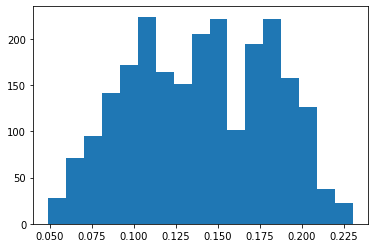

In [16]:
import matplotlib.pyplot as plt
means = np.array([ds[i][:7].mean() for i in range(len(ds))])

plt.hist(means, bins='auto')

In [13]:
th.tensor(ds[0]).unsqueeze(0).shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



torch.Size([1, 14, 16, 16, 16])

In [1]:
from htmd.ui import *

ModuleNotFoundError: No module named 'htmd'

In [18]:
inp = th.randn(1,14,16,16,16)
out = VerySimple().forward(inp)
print(out)


tensor([-0.7918, -1.2069])


In [ ]:


#random.seed(2253)

ds = ThermoNet2Dataset(df_train, train=True)

group_name  = '12caA' # 1
group_name  = '1a23A' # 6
#group_name  = '1a5eA'

group_item_indxs = ds.groups_info[group_name]
print('items: ', group_item_indxs)
if len(group_item_indxs)<2:
    print('default')

group_pair_indxs = random.sample(group_item_indxs,2)
print('samples: ', group_pair_indxs)

df1 = df_train.loc[group_pair_indxs[0]]
df2 = df_train.loc[group_pair_indxs[1]]
print(f'df1 ddg:{df1.ddG}, dt:{df1.dT}')
print(f'df2 ddg:{df2.ddG}, dt:{df2.dT}')

if df1.ddG is not None and df2.ddG is not None:
    ddG = df2.ddG - df1.ddG
else:
    ddG = None

if df1.dT is not None and df2.dT is not None:
    dT = df2.dT - df1.dT
else:
    dT = None
    
if ddG is None and dT is None:
    print('def')
else:
    print(f'merged: ddg:{ddG}, dt:{dT}')
    features = np.empty(df1.features.shape)
    features[:7] = df1.features[7:]
    features[7:] = df2.features[7:]
    
    


In [ ]:
for i in group_item_indxs:
    print(df_train.loc[i])
    print(df_train.loc[i].features[:7].mean())


In [ ]:
#!wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
#!bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
!conda install -c acellera htmd

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - htmd


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    acemd3-3.5.1               |       cuda1121_0        52.5 MB  acellera
    alsa-lib-1.2.6.1           |       h7f98852_0         578 KB  conda-forge
    ambertools-22.0            |   py37he444a17_3       102.1 MB  conda-forge
    anaconda-client-1.11.0     |     pyhd8ed1ab_1          72 KB  conda-forge
    arpack-3.7.0               |       hdefa2d7_2         215 KB  conda-forge
    astropy-4.3.1              |   py37hb1e94ed_2         7.7 MB  conda-forge
    astunparse-1.6.3           |     pyhd8ed1ab_0          15 KB  conda-forge


<div class="alert alert-block alert-danger" style="text-align:center; font-size:20px;">
    ❤️ Dont forget to ▲upvote▲ if you find this notebook usefull!  ❤️
</div>
